In [1]:
!pip install rasterio
!pip install fiona

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 14.2 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from scipy.stats import f_oneway, kruskal
from rasterio.mask import mask
import fiona
import matplotlib.colors as mcolors
from scipy.stats import pearsonr


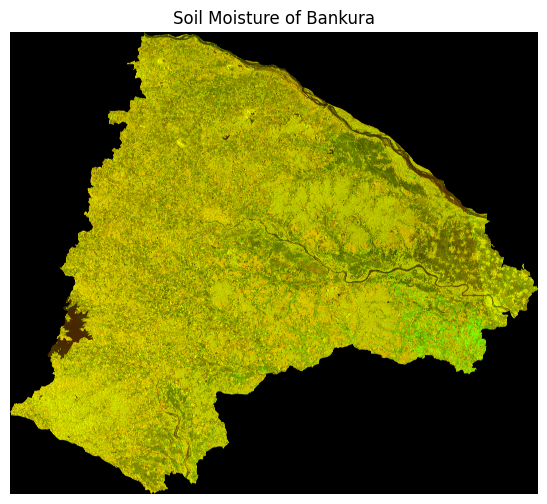

2274

In [4]:
w_path = '/content/drive/MyDrive/PYTHON_PROJeCT/SOIL_MOISTURE/IW_final.tif'

# Read the bands
with rasterio.open(w_path) as w_ds:
    band1 = w_ds.read(1).astype(np.float32)  # VV
    band2 = w_ds.read(2).astype(np.float32)  # VH
    w_transform = w_ds.transform
    w_crs = w_ds.crs

# Normalize
band1 /= np.percentile(band1, 95)
band2 /= np.percentile(band2, 95)
band1 = np.nan_to_num(band1, nan=0.0)
band2 = np.nan_to_num(band2, nan=0.0)

# Compose RGB (VV → Red, VH → Green)
rgb_image = np.stack((band1, band2, np.zeros_like(band1)), axis=-1)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(rgb_image)
plt.title('Soil Moisture of Bankura')
plt.axis('off')
plt.show()

# Save
np.save('rgb_image.npy', rgb_image)
del band1, band2
gc.collect()

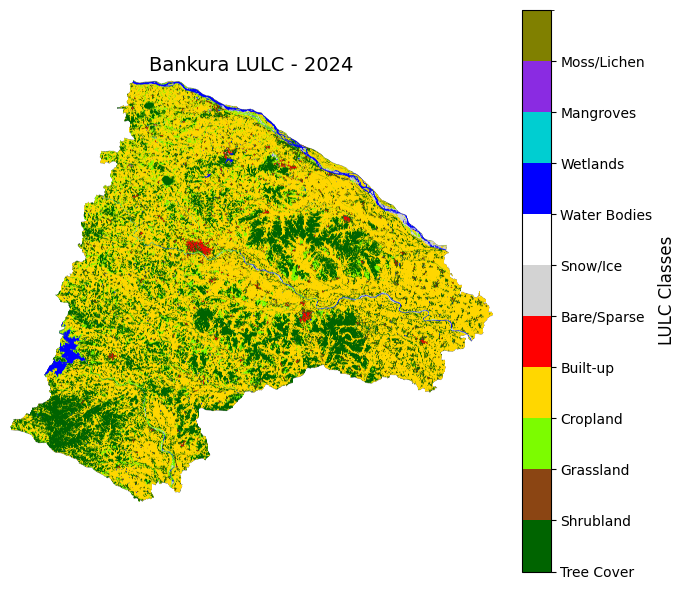

24

In [ ]:
lulc_path = "/content/drive/MyDrive/Bankura_LULC_2024_1.tif"

# LULC classes and colors
lulc_classes = {
    10: "Tree Cover", 20: "Shrubland", 30: "Grassland", 40: "Cropland", 50: "Built-up",
    60: "Bare/Sparse", 70: "Snow/Ice", 80: "Water Bodies", 90: "Wetlands",
    100: "Mangroves", 110: "Moss/Lichen"
}
lulc_colors = [
    "#006400", "#8B4513", "#7CFC00", "#FFD700", "#FF0000",
    "#D3D3D3", "#FFFFFF", "#0000FF", "#00CED1", "#8A2BE2", "#808000"
]
lulc_cmap = mcolors.ListedColormap(lulc_colors)
lulc_bounds = list(lulc_classes.keys()) + [120]
lulc_norm = mcolors.BoundaryNorm(lulc_bounds, lulc_cmap.N)

with rasterio.open(lulc_path) as src:
    lulc = src.read(1, masked=True)

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
img = ax.imshow(lulc, cmap=lulc_cmap, norm=lulc_norm)
ax.set_title("Bankura LULC - 2024", fontsize=14)
ax.axis("off")

# Colorbar
cbar = fig.colorbar(img, ax=ax)
cbar.set_ticks(list(lulc_classes.keys()))
cbar.set_ticklabels(list(lulc_classes.values()))
cbar.ax.set_ylabel("LULC Classes", fontsize=12)

plt.tight_layout()
plt.show()

del lulc
gc.collect()


In [ ]:
with rasterio.open(w_path) as w_ds:
    w_band = w_ds.read(1, masked=True).astype(np.float32)
    w_shape = w_band.shape

# 📥 Read and Resample LULC
with rasterio.open(lulc_path) as lulc_ds:
    if lulc_ds.shape != w_shape:
        print("Resampling LULC to match Soil Moisture shape...")
        lulc_masked = lulc_ds.read(
            1,
            out_shape=w_shape,
            resampling=Resampling.nearest,
            masked=True
        )
    else:
        lulc_masked = lulc_ds.read(1, masked=True)

# Convert to float before filling with NaN
lulc_resampled = lulc_masked.astype(np.float32).filled(np.nan)

# Save Intermediate Arrays

np.save('w_band.npy', w_band.filled(np.nan))  # Convert mask to NaN
np.save('lulc_resampled.npy', lulc_resampled)

# Free RAM
del w_band, lulc_resampled
gc.collect()

Resampling LULC to match Soil Moisture shape...


0

📌 Average Soil Moisture per LULC Class :

Tree Cover (Code 10): 19.6534 dB
Shrubland (Code 20): 19.6727 dB
Grassland (Code 30): 18.6998 dB
Cropland (Code 40): 18.5112 dB
Bare/Sparse (Code 60): 17.3955 dB
Wetlands (Code 90): 18.5795 dB


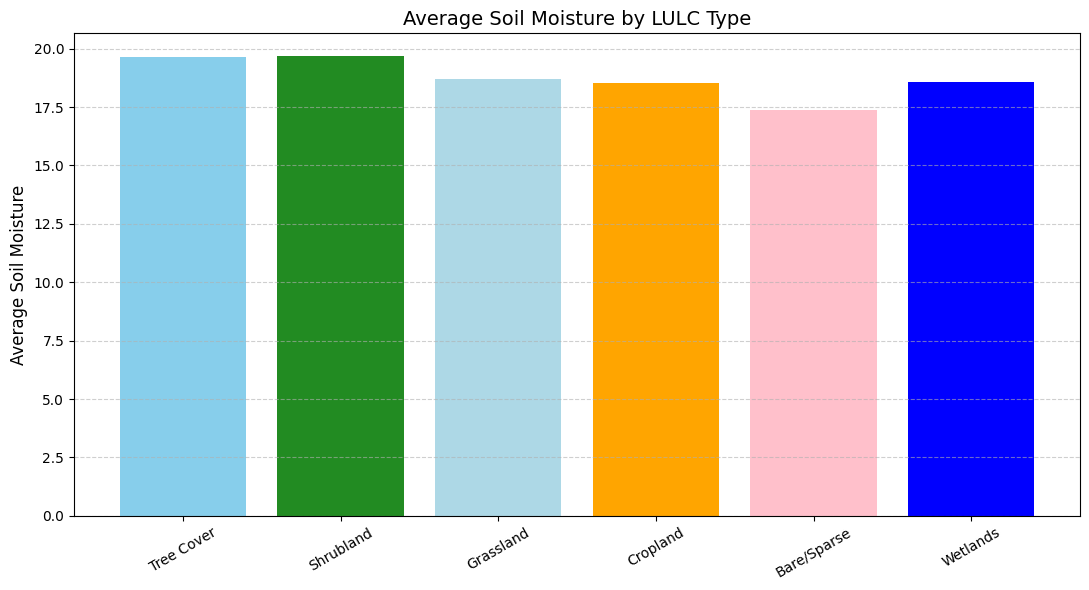

3424

In [ ]:
# Compute Average Soil Moisture by LULC Class
lulc_classes = {
    10: "Tree Cover", 20: "Shrubland", 30: "Grassland", 40: "Cropland",
    60: "Bare/Sparse", 70: "Snow/Ice", 90: "Wetlands",
    100: "Mangroves", 110: "Moss/Lichen"
}

# Load memory
w_band = np.load('w_band.npy', mmap_mode='r')
lulc_resampled = np.load('lulc_resampled.npy', mmap_mode='r')

# Get valid LULC codes
unique_codes = np.unique(lulc_resampled[~np.isnan(lulc_resampled)]).astype(int)

# Compute averages
avg_soil_moisture_db = []
labels = []

print("📌 Average Soil Moisture per LULC Class :\n")
for code in unique_codes:
    if code in lulc_classes:
        mask = (lulc_resampled == code)
        if np.any(mask):
            moisture_values = w_band[mask]
            moisture_values_db = 10 * np.log10(np.clip(moisture_values, 1e-6, None))
            avg_db = np.nanmean(moisture_values_db)
            print(f"{lulc_classes[code]} (Code {code}): {avg_db:.4f} dB")
            labels.append(lulc_classes[code])
            avg_soil_moisture_db.append(avg_db)

# Plot Average Soil Moisture by LULC
plt.figure(figsize=(11, 6))
plt.bar(labels, avg_soil_moisture_db, color=[
    'skyblue', 'forestgreen', 'lightblue', 'orange',
    'pink', 'blue', 'green', 'brown', 'purple'
])
plt.ylabel('Average Soil Moisture', fontsize=12)
plt.title('Average Soil Moisture by LULC Type', fontsize=14)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Clean up
del w_band, lulc_resampled
gc.collect()


In [ ]:
# Load memory-mapped arrays
w_band = np.load('w_band.npy', mmap_mode='r')
lulc_resampled = np.load('lulc_resampled.npy', mmap_mode='r')

# LULC classes dictionary (same as before)
lulc_classes = {
    10: "Tree Cover", 20: "Shrubland", 30: "Grassland", 40: "Cropland", 50: "Built-up",
    60: "Bare/Sparse", 70: "Snow/Ice", 80: "Water Bodies", 90: "Wetlands",
    100: "Mangroves", 110: "Moss/Lichen"
}

# Get valid codes (no NaNs)
unique_codes = np.unique(lulc_resampled[~np.isnan(lulc_resampled)]).astype(int)

# Dictionary to store LULC-wise soil moisture groups
lulc_groups = {}

print("\n📊 Grouping Soil Moisture Values by LULC Class...\n")

for code in unique_codes:
    if code in lulc_classes:
        mask = (lulc_resampled == code)
        if np.any(mask):
            sm_values = w_band[mask]
            sm_values = sm_values[~np.isnan(sm_values)]
            if sm_values.size > 0:
                lulc_groups[lulc_classes[code]] = sm_values  # DO NOT copy to list, keep array

# Extract for statistical tests
group_names = list(lulc_groups.keys())
group_values = list(lulc_groups.values())

# 🔬 One-way ANOVA
anova_stat, anova_p = f_oneway(*group_values)
print("🔬 One-way ANOVA Results")
print(f"F-statistic: {anova_stat:.4f}")
print(f"P-value: {anova_p:.4e}")
if anova_p < 0.05:
    print("→ Significant difference found between groups (p < 0.05)")
else:
    print("→ No significant difference found between groups (p ≥ 0.05)")

# 🔬 Kruskal-Wallis Test
kruskal_stat, kruskal_p = kruskal(*group_values)
print("\n🔬 Kruskal-Wallis Test Results")
print(f"H-statistic: {kruskal_stat:.4f}")
print(f"P-value: {kruskal_p:.4e}")
if kruskal_p < 0.05:
    print("→ Significant difference found between groups (p < 0.05)")
else:
    print("→ No significant difference found between groups (p ≥ 0.05)")

# Clean up
del w_band, lulc_resampled, group_values, lulc_groups
gc.collect()


📊 Grouping Soil Moisture Values by LULC Class...

🔬 One-way ANOVA Results
F-statistic: 1455714.3750
P-value: 0.0000e+00
→ Significant difference found between groups (p < 0.05)

🔬 Kruskal-Wallis Test Results
H-statistic: 9758323.5081
P-value: 0.0000e+00
→ Significant difference found between groups (p < 0.05)


0

In [ ]:
# Load memory-mapped arrays
w_band = np.load('w_band.npy', mmap_mode='r')
lulc_resampled = np.load('lulc_resampled.npy', mmap_mode='r')

# Get flattened views
w_band_flat = w_band.ravel()
lulc_flat = lulc_resampled.ravel()

valid_lulc_mask = np.isin(lulc_flat, list(lulc_classes.keys()))

valid_mask = valid_lulc_mask & ~np.isnan(w_band_flat)

encoded_lulc = lulc_flat[valid_mask]
soil_moisture_vals = w_band_flat[valid_mask]

corr_coef, p_val = pearsonr(encoded_lulc, soil_moisture_vals)

print(f"\n🔗 Pearson Correlation between LULC (encoded) and Soil Moisture:")
print(f"Correlation Coefficient (r): {corr_coef:.4f}")
print(f"P-value: {p_val:.4e}")

# Clean up
del w_band, lulc_resampled, encoded_lulc, soil_moisture_vals
gc.collect()


🔗 Pearson Correlation between LULC (encoded) and Soil Moisture:
Correlation Coefficient (r): -0.3244
P-value: 0.0000e+00


23